## **Gaussian Process with Observation Noise**

Modelling processes often involve some amount of noise or error which may arise from a multitude of sources. In the basic `Campaign` class with a default Gaussian Process estimator, the default assumption is that the noise is *homoskedastic* (constant noise everywhere), and this noise is approximated by the model during fitting.

In some cases, one may have information about the level of measurement noise/error in the data (e.g. from the specifications of a sensor module used to collect the data), and thus may want to include this information in the model.

This notebook will cover:
- homoskedastic Gaussian Process
- heteroskedastic Gaussian Process

In [ ]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# twinLab import
import twinlab as tl

### **Problem Formulation**

Here, we will formulate an exact function to do regression on, and subsequently add noise to the data.

In [2]:
# The true function
def oscillator(x):
    return np.cos((x - 5) / 2) ** 2 * x * 2

X = np.linspace(-15,15,100)[:,np.newaxis]
y = oscillator(X) # Arrange outputs as feature columns

n_data = 200
X_data = np.random.uniform(-10, 10, size=n_data)
y_data = oscillator(X_data)

### **Homoskedastic GP Campaign**

In `twinlab`, a homoskedastic GP model is exposed via the keyword argument `estimator_type="fixed_noise_gp"` provided to the `estimator_kwargs` dictionary during initialisation.

Additionally, a new `DataFrame` called `df_stdev`, containing the standard deviation of the observation noise/error, must be uploaded and its dataset_id added to the `campaign_params`. This additional table must contain the same columns as the mean data. Since the noise model is homoskedastic, the noise must be the same value everywhere. 

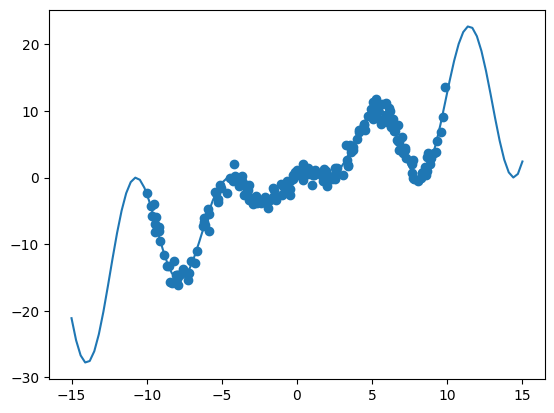

In [3]:
noise_scale = 1.0

# Add noise to data
y_data_homoskedastic = y_data + np.random.normal(scale=noise_scale, size=X_data.shape)

# Convert to dataframe
df = pd.DataFrame({'x': X_data, 'y': y_data_homoskedastic})

# Generate observation noise dataframe
df_stdev = pd.DataFrame({'y': np.full_like(y_data_homoskedastic, noise_scale)})

plt.plot(X,y)
plt.scatter(X_data, y_data_homoskedastic)
plt.show()

In [4]:
# Define the name of the dataset
dataset_id = "ObsNoise_Data"

# Upload the dataset to the cloud
tl.upload_dataset(df, dataset_id, verbose=True)

# Define the name of the std dataset
std_dataset_id = "ObsNoise_STD_Data"

# Upload the dataset to the cloud
tl.upload_dataset(df_stdev, std_dataset_id, verbose=True)

Dataframe is uploading.
Processing dataset.
Dataset ObsNoise_Data was processed.
Dataframe is uploading.
Processing dataset.
Dataset ObsNoise_STD_Data was processed.


In [5]:
# Initialise campaign
campaign_id = "HomoskedasticGP"

campaign_params = {
    "dataset_id": dataset_id,
    "dataset_std_id": std_dataset_id,
    "inputs": ['x'],                            
    "outputs": ['y'],
    "test_train_ratio": 0.75,                   
    "estimator": "gaussian_process_regression",
    'estimator_kwargs': {
        'estimator_type': 'fixed_noise_gp', # Keyword string to request homoskedastic model
    }
}                                        

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

Model HomoskedasticGP has begun training.


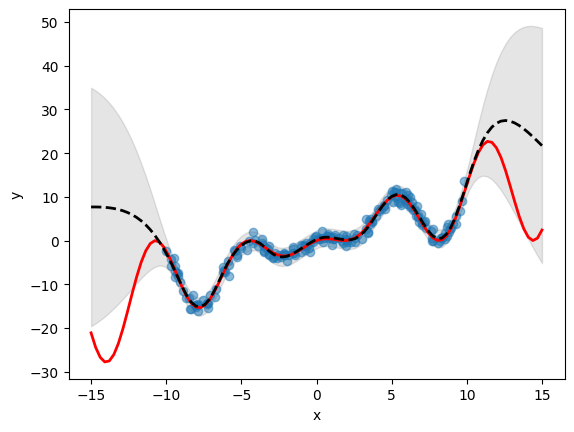

In [6]:
# Plot inference results
df_mean, df_stdev = tl.predict_campaign(pd.DataFrame(X, columns=["x"]), campaign_id)
y_mean, y_stdev = df_mean.values, df_stdev.values

plt.fill_between(X.flatten(), 
                 (y_mean - 1.96*y_stdev).flatten(), 
                 (y_mean + 1.96*y_stdev).flatten(), 
                 color='k', alpha=0.1)

plt.scatter(df['x'], df['y'], alpha=0.5, label='Training Data')
plt.xlabel('x'); plt.ylabel('y')

plt.plot(X, y, c='r', linewidth=2)
plt.plot(X, y_mean, c='k', linewidth=2, linestyle='dashed')
plt.show()

### **Heteroskedastic GP Campaign**

In `twinlab`, a heteroskedastic GP model is exposed via the keyword argument `estimator_type="heteroskedastic_gp"` provided to the `estimator_kwargs` dictionary during initialisation.

Additionally, a new `DataFrame` called `df_stdev`, containing the standard deviation of the observation noise/error, must be uploaded and its dataset_id added to the `campaign_params`. This additional table must contain the same columns as the mean data.

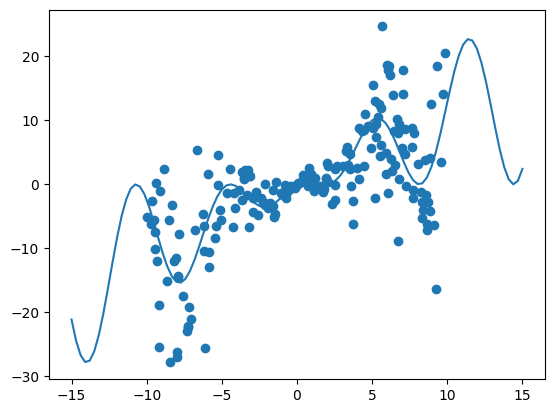

In [7]:
noise_scale = 0.5

# Add noise to data
y_data_heteroskedastic = y_data + np.random.normal(scale=noise_scale, size=X_data.shape[0]) * X_data*2

# Convert to dataframe
df = pd.DataFrame({'x': X_data, 'y': y_data_heteroskedastic})

# Generate observation noise dataframe
df_stdev = pd.DataFrame({'y': X_data*2})

plt.plot(X,y)
plt.scatter(X_data, y_data_heteroskedastic)
plt.show()

In [8]:
# Define the name of the dataset
dataset_id = "ObsNoise_Data"

# Upload the dataset to the cloud
tl.upload_dataset(df, dataset_id, verbose=True)

# Define the name of the std dataset
std_dataset_id = "ObsNoise_STD_Data"

# Upload the dataset to the cloud
tl.upload_dataset(df_stdev, std_dataset_id, verbose=True)

Dataframe is uploading.
Processing dataset.
Dataset ObsNoise_Data was processed.
Dataframe is uploading.
Processing dataset.
Dataset ObsNoise_STD_Data was processed.


In [9]:
# Initialise campaign
campaign_id = "HeteroskedasticGP"

campaign_params = {
    "dataset_id": dataset_id,
    "dataset_std_id": std_dataset_id,
    "inputs": ['x'],                            
    "outputs": ['y'],
    "test_train_ratio": 0.75,                   
    "estimator": "gaussian_process_regression",
    'estimator_kwargs': {
        'estimator_type': 'heteroskedastic_gp', # Keyword string to request homoskedastic model
    }
}                                        

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

Model Heteroskedastic has begun training.


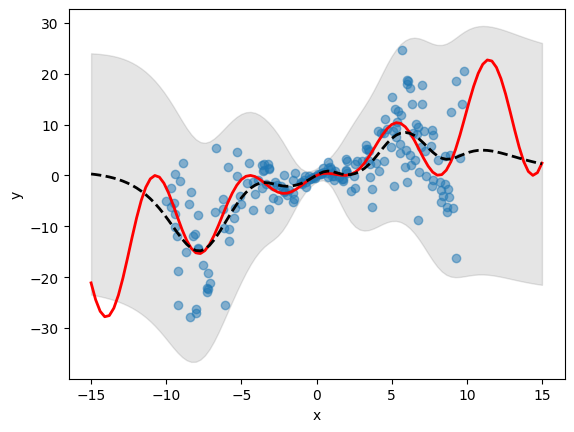

In [10]:
# Plot inference results
df_mean, df_stdev = tl.predict_campaign(pd.DataFrame(X, columns=["x"]), campaign_id)
y_mean, y_stdev = df_mean.values, df_stdev.values

plt.fill_between(X.flatten(), 
                 (y_mean - 1.96*y_stdev).flatten(), 
                 (y_mean + 1.96*y_stdev).flatten(), 
                 color='k', alpha=0.1)

plt.scatter(df['x'], df['y'], alpha=0.5, label='Training Data')
plt.xlabel('x'); plt.ylabel('y')

plt.plot(X, y, c='r', linewidth=2)
plt.plot(X, y_mean, c='k', linewidth=2, linestyle='dashed')
plt.show()

In [11]:
# Delete campaigns and dataset
tl.delete_campaign("HeteroskedasticGP")
tl.delete_campaign("HomoskedasticGP")

tl.delete_dataset("ObsNoise_STD_Data")
tl.delete_dataset("ObsNoise_Data")